## Business Problem 
Diabetes is one of the deadliest and chronic diseases. About one in seven U.S.
adults has diabetes now. By 2050, as many as one in three may become diabetic.
Many complications occur if diabetes remains untreated and unidentified.
Identifying patients who are at high-risk of becoming diabetic allows early medical
interventions.

Data Source: https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [145]:
diabetes_data = pd.read_csv("diabetes.csv")

### Data Exploration

In [146]:
diabetes_data.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [147]:
#checking for null values
diabetes_data.apply(lambda x: sum(x.isnull()), axis = 0)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [148]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### When we see the data distribution some values seem to be erroneous.
#### Having 17 pregnancies, 0 glucose, 0 blood pressure, 0 as skin thickness, 0 insulin does not make sense. We will plot this data to further investigate such cases.

[Text(0, 0.5, 'count'), Text(0.5, 0, 'Insulin')]

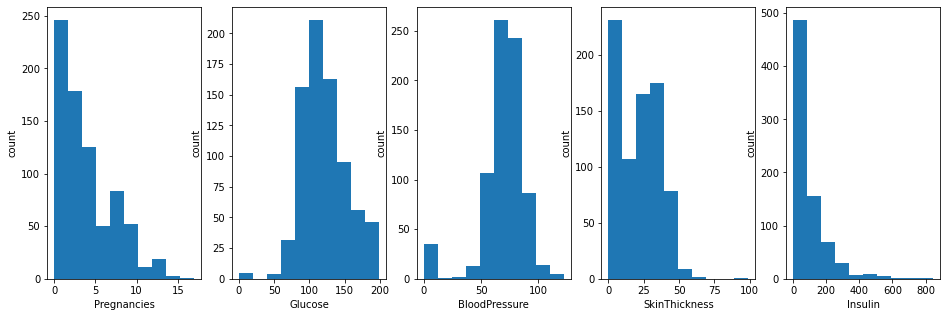

In [149]:
#Histogram

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (16,5))

ax1.hist(diabetes_data['Pregnancies'])
ax1.set(xlabel = 'Pregnancies', ylabel='count')

ax2.hist(diabetes_data['Glucose'])
ax2.set(xlabel = 'Glucose', ylabel='count')

ax3.hist(diabetes_data['BloodPressure'])
ax3.set(xlabel = 'BloodPressure', ylabel='count')

ax4.hist(diabetes_data['SkinThickness'])
ax4.set(xlabel = 'SkinThickness', ylabel='count')

ax5.hist(diabetes_data['Insulin'])
ax5.set(xlabel = 'Insulin', ylabel='count')




[Text(0, 0.5, 'count'), Text(0.5, 0, 'Insulin')]

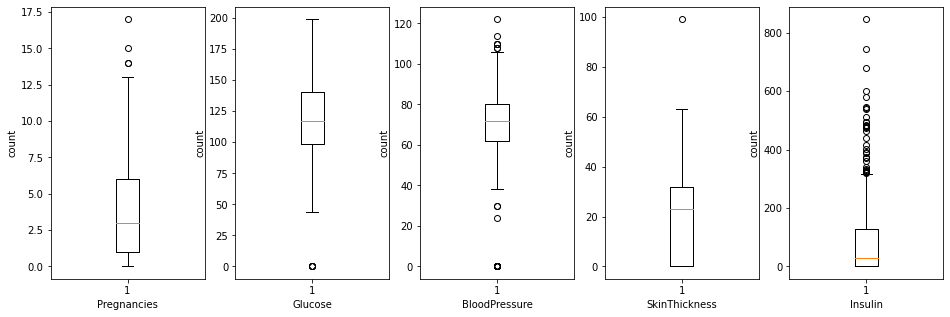

In [150]:
#BoxPlot

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (16,5))

ax1.boxplot(diabetes_data['Pregnancies'])
ax1.set(xlabel = 'Pregnancies', ylabel='count')

ax2.boxplot(diabetes_data['Glucose'])
ax2.set(xlabel = 'Glucose', ylabel='count')

ax3.boxplot(diabetes_data['BloodPressure'])
ax3.set(xlabel = 'BloodPressure', ylabel='count')

ax4.boxplot(diabetes_data['SkinThickness'])
ax4.set(xlabel = 'SkinThickness', ylabel='count')

ax5.boxplot(diabetes_data['Insulin'])
ax5.set(xlabel = 'Insulin', ylabel = 'count')

When we see the above plots we see that,
1. Pregnancies have some values which are more than 12, and it is seems to be unlikely to have such data and hence we need to treat those values as outliers
2. Having Glucose level 0 in unreasonable and hence that needs to be treated as outlier too
3. On the upper side the Blood Pressure seems to be high but within limits but on the lower end it seems to be errorneous data where the blood pressure is 0 abd hence that neds to be treated as outlier too
4. SkinThickness graph is right skewed and having 0 skin thickness is defnitely some error, this data can be replaces by median or mean values. We need some data transformation here too


In [151]:
## Treating the outliers by removing them
def remove_outliers(col_name, df):
    mean = df[col_name].mean()
    std = df[col_name].std()
    lower_cutoff, upper_cutoff = mean - 3*std, mean + 3*std
    df1 = df[(df[col_name] < upper_cutoff) & (df[col_name] > lower_cutoff)]
    return df1



In [152]:
diabetes_data = remove_outliers('Pregnancies', diabetes_data)
diabetes_data = remove_outliers('Glucose', diabetes_data)
diabetes_data = remove_outliers('BloodPressure', diabetes_data)
diabetes_data = remove_outliers('SkinThickness', diabetes_data)

In [153]:
diabetes_data.Glucose = diabetes_data.Glucose.replace(0, diabetes_data.Glucose.mean())
diabetes_data.BloodPressure = diabetes_data.BloodPressure.replace(0, diabetes_data.BloodPressure.median())
diabetes_data.SkinThickness = diabetes_data.SkinThickness.replace(0, diabetes_data.SkinThickness.mean())
diabetes_data.Insulin = diabetes_data.Insulin.replace(0, diabetes_data.Insulin.median())


[Text(0, 0.5, 'count'), Text(0.5, 0, 'Insulin')]

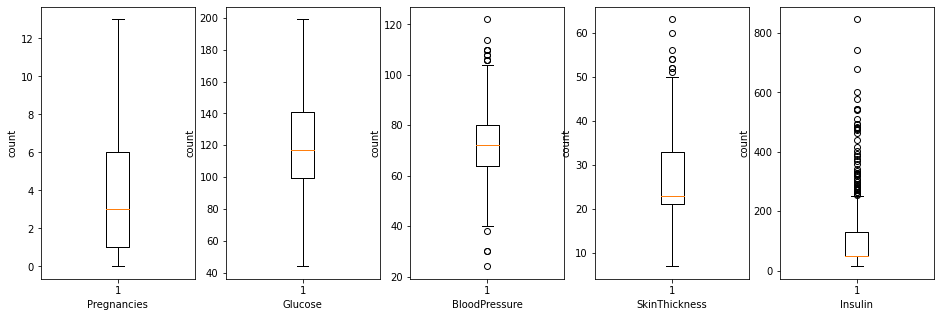

In [154]:
#BoxPlot

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (16,5))

ax1.boxplot(diabetes_data['Pregnancies'])
ax1.set(xlabel = 'Pregnancies', ylabel='count')

ax2.boxplot(diabetes_data['Glucose'])
ax2.set(xlabel = 'Glucose', ylabel='count')

ax3.boxplot(diabetes_data['BloodPressure'])
ax3.set(xlabel = 'BloodPressure', ylabel='count')

ax4.boxplot(diabetes_data['SkinThickness'])
ax4.set(xlabel = 'SkinThickness', ylabel='count')

ax5.boxplot(diabetes_data['Insulin'])
ax5.set(xlabel = 'Insulin', ylabel = 'count')

Treating the variables to remove the outliers and populate relevant data where required

In [155]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000
mean,3.803596,121.650069,72.452282,26.917290,106.278008,32.259059,0.476813,33.298755,0.338866
std,3.269118,30.539708,12.420445,9.298621,102.724055,7.291042,0.335380,11.815729,0.473652
min,0.000000,44.000000,24.000000,7.000000,14.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.500000,64.000000,21.222683,48.000000,27.400000,0.245000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,48.000000,32.100000,0.380000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,33.000000,130.000000,36.550000,0.630000,41.000000,1.000000
max,13.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Splitting Data into Train and Test

In [156]:
y = diabetes_data['Outcome']
x = diabetes_data.drop('Outcome', axis = 1)

In [157]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 50)

### Logistic Regression

In [158]:
logistic_model = LogisticRegression()
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg_cv=GridSearchCV(logistic_model,grid,cv=10)
logreg_cv.fit(x_train,y_train)

C:\Users\meha\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\meha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\meha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO

C:\Users\meha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\meha\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\meha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO

C:\Users\meha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\meha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\meha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\meha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\meha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [159]:
logreg_cv.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [160]:
logistic_model=LogisticRegression(**logreg_cv.best_params_)
logistic_model.fit(x_train, y_train)
log_model_prediction = logistic_model.predict(x_test)

C:\Users\meha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [161]:
log_conf_matrix = confusion_matrix(y_test, log_model_prediction)
log_model_report = classification_report(y_test, log_model_prediction)

print("=============Confusion Matrix=============")
print(log_conf_matrix)

print("=============Classification Report=============")
print(log_model_report)

=============Confusion Matrix=============
[[119  24]
 [ 31  43]]
=============Classification Report=============
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       143
           1       0.64      0.58      0.61        74

    accuracy                           0.75       217
   macro avg       0.72      0.71      0.71       217
weighted avg       0.74      0.75      0.74       217



Text(0, 0.5, 'True Positive Rate')

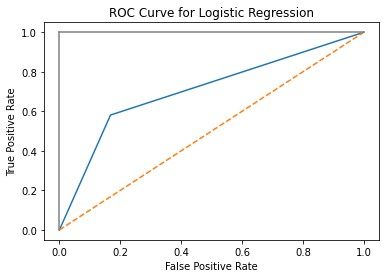

In [162]:
false_pos_rate, true_pos_rate, threshhold = roc_curve(y_test, log_model_prediction)
plt.title("ROC Curve for Logistic Regression")
plt.plot(false_pos_rate, true_pos_rate)
plt.plot([0, 1], ls="--")
plt.plot([0,0],[1, 0] , c="grey") 
plt.plot([1, 1] , c="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

### Random Forest Classification

In [163]:
random_forest_model = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [100, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,3,4,5,6],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [164]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'log2',
 'n_estimators': 100}

In [165]:
random_forest_model = RandomForestClassifier(**CV_rfc.best_params_)
random_forest_model.fit(x_train, y_train)
rf_predictions = random_forest_model.predict(x_test)

In [166]:
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
rf_classification_report = classification_report(y_test, rf_predictions)

print("=============Confusion Matrix=============")
print(rf_conf_matrix)

print("=============Classification Report=============")
print(rf_classification_report)

=============Confusion Matrix=============
[[123  20]
 [ 27  47]]
=============Classification Report=============
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       143
           1       0.70      0.64      0.67        74

    accuracy                           0.78       217
   macro avg       0.76      0.75      0.75       217
weighted avg       0.78      0.78      0.78       217



Text(0, 0.5, 'True Positive Rate')

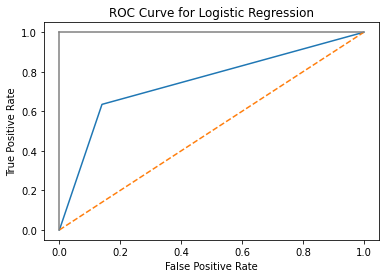

In [167]:
rf_false_pos_rate, rf_true_pos_rate, rf_threshhold = roc_curve(y_test, rf_predictions)
plt.title("ROC Curve for Logistic Regression")
plt.plot(rf_false_pos_rate, rf_true_pos_rate)
plt.plot([0, 1], ls="--")
plt.plot([0,0],[1, 0] , c="grey") 
plt.plot([1, 1] , c="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

### SVM Classifier

In [169]:
svm_model = SVC(random_state = 42)

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(svm_model, param_grid, refit = True, verbose = 3) 
grid.fit(x_train, y_train) 


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.657, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.663, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.663, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.663, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.663, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.657, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.663, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.663, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.663, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.663, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.657, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .

[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.693, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.733, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.713, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.755, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.743, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.752, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.743, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    4.6s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [170]:
grid.best_params_

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

In [171]:
svm_model = SVC(**grid.best_params_)
svm_model.fit(x_train, y_train)
svm_predictions = svm_model.predict(x_test)

In [172]:
svm_conf_matrix = confusion_matrix(y_test, svm_predictions)
svm_classification_report = classification_report(y_test, svm_predictions)

print("=============Confusion Matrix=============")
print(rf_conf_matrix)

print("=============Classification Report=============")
print(rf_classification_report)

=============Confusion Matrix=============
[[123  20]
 [ 27  47]]
=============Classification Report=============
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       143
           1       0.70      0.64      0.67        74

    accuracy                           0.78       217
   macro avg       0.76      0.75      0.75       217
weighted avg       0.78      0.78      0.78       217



Text(0, 0.5, 'True Positive Rate')

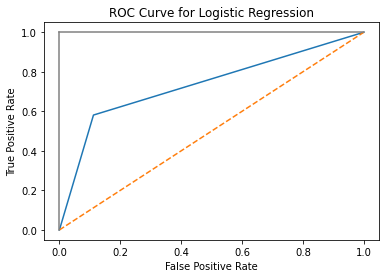

In [173]:
svm_false_pos_rate, svm_true_pos_rate, svm_threshhold = roc_curve(y_test, svm_predictions)
plt.title("ROC Curve for Logistic Regression")
plt.plot(svm_false_pos_rate, svm_true_pos_rate)
plt.plot([0, 1], ls="--")
plt.plot([0,0],[1, 0] , c="grey") 
plt.plot([1, 1] , c="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

### Conclusion
In this case we are building a machine learning model to accurately predict whether or not the patients in the dataset have diabetes or not. This can massively help in preempting the onset on diabetes which can help in propoer cure and treatment. This would help in decreasing the fatalities. Diabetes can lead to other serious disorders like heart attack, stroke, etc. Thus, in this case any False Negative would pose a greater threat then a False positive. If a person is predicted to have diabetes when he doesn't (False Positive) the worst that could happen is he would have to do tests to confirm and maybe adjust his or her lifestyle but if he goes undetected (False Negative) when he indeed is likely to get diabetes then it can delay the treatment and worsen patients condition.